# Annotator Analysis for TREC Deep Learning Queries

This notebook provides a simple data ingestion pipeline from which further analysis can be derived as a group

## Data Ingestion

In [139]:
from ir_measures import read_trec_qrels
import ir_datasets as irds
import pandas as pd
import os

In [140]:
DATASET = "msmarco-passage/trec-dl-2019/judged"
qrel_directory = '../judgments/pilot-round-01/qrels/'

In [141]:

dataset = irds.load(DATASET)
original_qrels = pd.DataFrame(dataset.qrels_iter())


In [142]:
all_qrels = []
for file in os.listdir(qrel_directory):
    if file.endswith('.txt'):
        qrels = pd.DataFrame(read_trec_qrels(qrel_directory + file))
        annotator = file.replace('.txt', '').replace('-qrels', '')
        qrels['annotator'] = annotator
        all_qrels.append(qrels)

all_qrels = pd.concat(all_qrels)

## Helper Classes

In [143]:
import logging
import numpy as np 
from sklearn import metrics
from scipy.stats import ttest_ind

class TrecQrel:
    def __init__(self, filename=None, qrels_header=["query","q0","docid","rel"]):

        #TODO: support to check whether the fields match.
        if filename:
            self.read_qrel(filename, qrels_header)
        else:
            self.filename = None
            self.qrels_data = None

    def __repr__(self):
        return self.__str__()

    def __str__(self):
        if self.filename:
            return "Data from file %s" % (self.get_full_filename_path())
        else:
            return "Data file not set yet"

    def __filter_topics(self, df, topics):
        if type(topics) is list:
            topics = set(topics)
        if type(topics) is not set:
            print("ERROR: topics should be a set")
            return None
        return df[df["query"].apply(lambda x: x in topics)]

    def print_subset(self, filename, topics=None, labels=None, another_qrel=None):
        """
            Creates a new qrel with name 'filename' based on the selected topics or labels.

            A common use case is to have all documents that appear in another qrel. For that,
            use 'another_qrel' parameter.
        """

        if another_qrel is None and labels is None and topics is None:
            print("You should assign a set of labels, topics or at least input another qrel to be filtered.")
            return

        dslice = None
        if topics is not None and labels is None:
            dslice = self.qrels_data[self.qrels_data["query"].apply(lambda x: x in set(topics))]
        elif labels is not None and topics is None:
            dslice = self.qrels_data[self.qrels_data["rel"].apply(lambda x: x in set(labels))]
        elif labels is not None and topics is not None:
            dslice = self.qrels_data[(self.qrels_data["query"].apply(lambda x: x in set(topics))) &
                    (self.qrels_data["rel"].apply(lambda x: x in set(labels)))]

        if another_qrel:
            if dslice is None:
                dslice = self.qrels_data.copy()
            dslice = pd.merge(dslice, another_qrel.qrels_data, on=["query","q0","docid"])
            dslice["rel"] = dslice["rel_x"]
            del dslice["rel_y"]
            del dslice["rel_x"]

        dslice[["query", "q0", "docid", "rel"]].to_csv(filename, sep=" ", header=False, index=False)
        print("File %s writen." % (filename))

    @classmethod
    def from_dataframe(cls, df):
        """
            Create a TrecQrel object from a pandas dataframe.
        """
        t = TrecQrel()
        t.qrels_data = df.rename(columns={"query_id":"query","doc_id":"docid","relevance":"rel", 'iteration':'q0'})[["query","q0","docid","rel"]]
        return t

    def read_qrel(self, filename, qrels_header=None):
        # Replace with default argument for qrel_header
        if qrels_header is None:
            qrels_header = ["query", "q0", "docid", "rel"]

        # Set filename
        self.filename = filename

        # Read data from file
        self.qrels_data = pd.read_csv(filename, sep="\s+", names=qrels_header)

        # Enforce string type on docid column (if present)
        if "docid" in self.qrels_data:
            self.qrels_data["docid"] = self.qrels_data["docid"].astype(str)
        # Enforce string type on q0 column (if present)
        if "q0" in self.qrels_data:
            self.qrels_data["q0"] = self.qrels_data["q0"].astype(str)
        # Enforce string type on query column (if present)
        if "query" in self.qrels_data:
            self.qrels_data["query"] = self.qrels_data["query"].astype(str)

        # Removes the files that were not judged:
        self.qrels_data = self.qrels_data[self.qrels_data["rel"] >= 0]

    def compare_with(self, another_qrel, topics=None):
        """
            Compare two qrels for a given set of topics.
            Returns means and checks for statistical significant differences.
            Only compares documents that are available in both sets.
            Use 'topics' parameter if you want to filter even further.
        """
        if topics is not None:
            dslice = self.__filter_topics(self.qrels_data, topics)
            oslice = self.__filter_topics(another_qrel.qrels_data, topics)
        else:
            dslice = self.qrels_data
            oslice = another_qrel.qrels_data

        merged = pd.merge(dslice, oslice, on=["query","q0","docid"])
        a = merged["rel_x"]
        b = merged["rel_y"]
        s, p = ttest_ind(a,b)
        print("This:  %.2f - %.2f" % (a.mean(), a.std()))
        print("Other: %.2f - %.2f" % (b.mean(), b.std()))
        print("significance: ", p)
        print("number of examples: ", a.shape[0])
        return (a.mean(), a.std(), b.mean(), b.std(), p, a.shape[0])

    def describe(self, topics=None):
        if topics is not None:
            dslice = self.__filter_topics(self.qrels_data, topics)
            if dslice is not None:
                return dslice["rel"].describe()
        else:
            return self.qrels_data["rel"].describe()

    def topics(self):
        return set(self.qrels_data["query"].unique())

    def topics_intersection_with(self, another_qrel):
        return self.topics().intersection(another_qrel.topics())

    def fill_up(self, another_qrel):
        """
            Complete the judgments for topics that have no judgement yet. It does not change anything in topics that have
            already some judgment.
        """
        new_topics = another_qrel.topics() - self.topics()
        for topic in new_topics:
            new_data = another_qrel.qrels_data[another_qrel.qrels_data["query"] == topic]
            self.qrels_data = pd.concat((self.qrels_data,new_data))
            logging.warning("Added topic %s" % str(topic))

    def get_full_filename_path(self):
        return os.path.abspath(os.path.expanduser(self.filename))

    def get_filename(self):
        return os.path.basename(self.get_full_filename_path())

    def get_number_of(self, label, topics=None):
        if topics is not None:
            dslice = self.qrels_data[self.qrels_data["query"].apply(lambda x: x in set(topics))]
            return (dslice["rel"] == label).sum()
        else:
            return (self.qrels_data["rel"] == label).sum()

    def check_kappa(self, another_qrel):
        """
            Kappa coeficient for binary data only.
        """
        # TODO: check if there are only two categories.
        r = pd.merge(self.qrels_data, another_qrel.qrels_data, on=["query","q0","docid"]) # TODO: rename fields as done in trec_res
        a, b = r["rel_x"], r["rel_y"]
        p0 = 1. * (a == b).sum() / a.shape[0]
        a_true_percentage = 1. * a.sum() / a.shape[0]
        b_true_percentage = 1. * b.sum() / b.shape[0]
        pe = (a_true_percentage * b_true_percentage) + ((1. - a_true_percentage) * (1. - b_true_percentage))
        print("P0: %.2f, Pe = %.2f" % (p0, pe))
        return (p0 - pe) / (1.0 - pe)

    def check_overlap(self, another_qrel, min_rel_label=1):
        r = pd.merge(self.qrels_data, another_qrel.qrels_data, on=["query","q0","docid"]) # TODO: rename fields as done in trec_res
        intersection = r[(r["rel_x"] >= min_rel_label) & (r["rel_y"] >= min_rel_label)]
        union = r[(r["rel_x"] >= min_rel_label) | (r["rel_y"] >= min_rel_label)]
        return 1. * intersection.shape[0] / union.shape[0]

    def check_jaccard(self, another_qrel, topics=None):
        # TODO
        pass

    def check_confusion_matrix(self, another_qrel, topics=None, labels=None):
        """
            Returns a confusion matrix for the topics that this qrel and another_qrel have in common.
            Use the paramenters topics and labels to restrict even more the topics and labels shown.
        """
        r = pd.merge(self.qrels_data, another_qrel.qrels_data, on=["query","q0","docid"]) # TODO: rename fields as done in trec_res
        if topics:
            r = self.__filter_topics(r, topics)
            if r is None:
                print("ERROR in filtering topics")
                return None
            print("Resulting topics being used: ", r["query"].unique())
        return metrics.confusion_matrix(r["rel_x"], r["rel_y"], labels=labels)

    def explore_agreement(self, another_qrel, topic):
        """
            Giving another set of relevance assessments and a topic, it returns for each document whether or not an agreement was found.
        """
        slice1 = self.qrels_data[self.qrels_data["query"] == topic]
        slice2 = another_qrel.qrels_data[another_qrel.qrels_data["query"] == topic]

        return pd.merge(slice1, slice2, on=["query","q0","docid"])

    def check_agreement(self, another_qrel, topics=None, labels=None):

        if labels is not None:
            #TODO: add support for filtering some labels
            print("SORRY LABEL SUPPORT NOT IMPLEMENTED YET")
            return None

        r = pd.merge(self.qrels_data, another_qrel.qrels_data, on=["query","q0","docid"]) # TODO: rename fields as done in trec_res

        if r.shape[0] == 0:
            print("No registers in common")
            return np.nan

        if topics:
            agreements = {}
            for topic in topics:
                rt = r[r["query"] == topic]
                if rt.shape[0] == 0:
                    print("ERROR: invalid topic:", topic)
                    agreements[topic] = np.nan
                    continue

                agreements[topic] = 1.0 * (rt["rel_x"] == rt["rel_y"]).sum() / rt.shape[0]
            return agreements

        return 1.0 * (r["rel_x"] == r["rel_y"]).sum() / r.shape[0]

    def pairwise_matrix(self, another_qrel):
        r = pd.merge(self.qrels_data, another_qrel.qrels_data, on=["query","q0","docid"])
        m = np.zeros((3,3))
        def fmap(a,b):
            if a < b:
                return 0
            elif a == b:
                return 1
            return 2
        for t in r["query"].unique():
            tslice = r[r["query"] == t]
            vs = tslice[["docid","rel_x", "rel_y"]].values
            for i in range(vs.shape[0]):
                for j in range(i, vs.shape[0]):
                    m[fmap(vs[i][1],vs[i][2])][fmap(vs[j][1],vs[j][2])] += 1

        print("Pairwise Agreement: %.2f " % (1.* (m[0][0] + m[1][1] + m[2][2]) / m.sum()))
        print("Total Disagement: %.2f " % (1.* (m[0][2] + m[2][0]) / m.sum()))
        return m

    def merge_with(self, another_qrel, operation="or", keep_all=False, filename=None):

        if keep_all:
            r = pd.merge(self.qrels_data, another_qrel.qrels_data, on=["query","q0","docid"], how="outer")
            r.fillna(-1, inplace=True)
            r["q0"] = r["q0"].astype(int)
            # TODO: not desirable as this will limit the queries to be integer
            r["query"] = r["query"].astype(int)

        else:
            r = pd.merge(self.qrels_data, another_qrel.qrels_data, on=["query","q0","docid"])

        if operation == "or":
            r["rel"] = r[["rel_x", "rel_y"]].apply(max, axis=1)
        elif operation == "and":
            r["rel"] = r[["rel_x", "rel_y"]].apply(min, axis=1)
        else:
            print("ERROR: No such operation %s. Options are 'or', 'and'." % (operation))
            return None

        if keep_all:
            r["rel"] = np.where(r["rel_y"] < 0, r["rel_x"], r["rel"])
            r["rel"] = np.where(r["rel_x"] < 0, r["rel_y"], r["rel"])

        r["rel"] = r["rel"].astype(int)

        if filename:
            r[["query", "q0", "docid", "rel"]].to_csv(filename, sep=" ", header=False, index=False)
            print("File %s writen." % (filename))

        return r[["query", "q0", "docid", "rel"]]

    def get_judgement(self, document, topic):
        """
        Returns "rel" value if the pair document-topic is found.
        Else, returns -1.
        """
        returned = self.qrels_data.loc[(self.qrels_data["docid"] == document) & (self.qrels_data["query"] == topic)]
        if returned.shape[0] > 1:
            print("ERROR: more than one value returned.")
            return returned
        elif returned.shape[0] == 1:
            return returned["rel"].values[0]
        else:
            return -1

    def get_document_names_for_topic(self, topicX):
        """
            return a set with the names of all documents judged for topic X.
        """
        return set(self.qrels_data[self.qrels_data["query"] == topicX]["docid"])

## Preliminary Analysis

In [144]:
import seaborn as sns
import matplotlib.pyplot as plt
#import trectools as tt

### Subset to relevant qrels

In [145]:
qids = all_qrels['query_id'].unique()
docs_ids = all_qrels['doc_id'].unique()
original_qrels_filtered = original_qrels[original_qrels['query_id'].isin(qids)]
original_qrels = original_qrels_filtered[original_qrels_filtered['doc_id'].isin(docs_ids)]

### Annotator Analysis

<AxesSubplot: xlabel='relevance', ylabel='Count'>

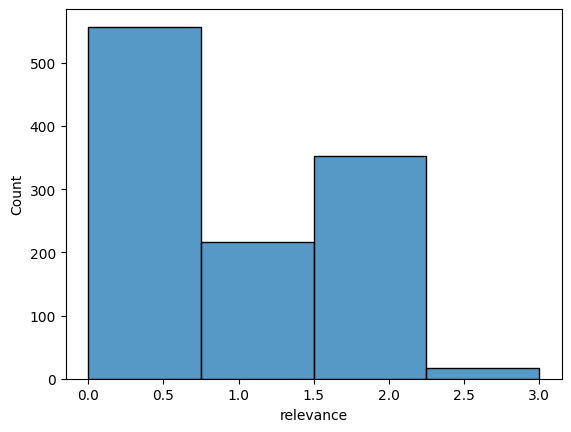

In [146]:
# sns histogram of relevance 
sns.histplot(data=original_qrels_filtered, x='relevance', bins=4)

<AxesSubplot: xlabel='relevance', ylabel='Count'>

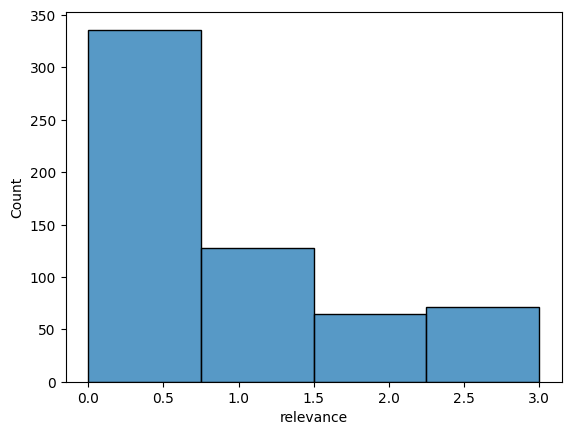

In [147]:
tmp_all_qrels = all_qrels[all_qrels['annotator']!= 'ground-truth']
sns.histplot(data=tmp_all_qrels, x='relevance', bins=4)

<AxesSubplot: xlabel='relevance', ylabel='Count'>

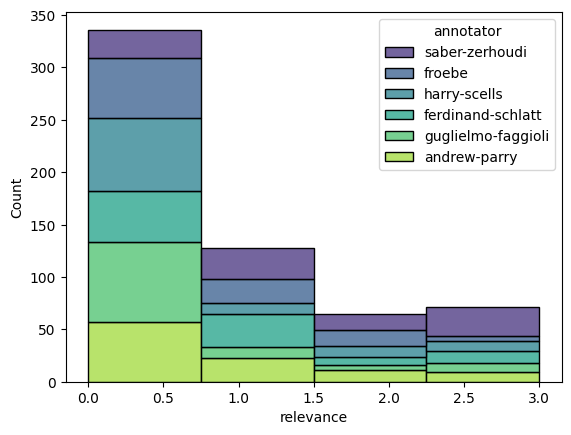

In [148]:
sns.histplot(data=tmp_all_qrels, x='relevance', bins=4, hue='annotator', multiple="stack", palette='viridis')

In [149]:
original_qrels_object = TrecQrel.from_dataframe(original_qrels_filtered)

In [150]:
for annotator, qrel in all_qrels.groupby('annotator'):
    qrel_object = TrecQrel.from_dataframe(qrel)
    original_qrels_object.check_kappa(qrel_object)


P0: nan, Pe = nan
P0: nan, Pe = nan
P0: nan, Pe = nan
P0: nan, Pe = nan
P0: nan, Pe = nan
P0: nan, Pe = nan
P0: nan, Pe = nan


/tmp/ipykernel_723566/487592143.py:167: RuntimeWarning: invalid value encountered in scalar divide
  p0 = 1. * (a == b).sum() / a.shape[0]
/tmp/ipykernel_723566/487592143.py:168: RuntimeWarning: invalid value encountered in scalar divide
  a_true_percentage = 1. * a.sum() / a.shape[0]
/tmp/ipykernel_723566/487592143.py:169: RuntimeWarning: invalid value encountered in scalar divide
  b_true_percentage = 1. * b.sum() / b.shape[0]
/tmp/ipykernel_723566/487592143.py:167: RuntimeWarning: invalid value encountered in scalar divide
  p0 = 1. * (a == b).sum() / a.shape[0]
/tmp/ipykernel_723566/487592143.py:168: RuntimeWarning: invalid value encountered in scalar divide
  a_true_percentage = 1. * a.sum() / a.shape[0]
/tmp/ipykernel_723566/487592143.py:169: RuntimeWarning: invalid value encountered in scalar divide
  b_true_percentage = 1. * b.sum() / b.shape[0]
/tmp/ipykernel_723566/487592143.py:167: RuntimeWarning: invalid value encountered in scalar divide
  p0 = 1. * (a == b).sum() / a.shap